In [1]:
import xarray as xr
from pathlib import Path
import numpy as np

import functions.data_wrangling as data

In [2]:
path = Path('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/1.1_pdSST-pdSIC/epfz/FGOALS-f3-L')
nc_files = list(path.glob('*.nc'))

In [3]:
ds = xr.open_mfdataset(
    nc_files,
    combine='nested',
    concat_dim='ens_ax',
)
ds

<xarray.Dataset>
Dimensions:  (ens_ax: 100, time: 15, plev: 8, lat: 180)
Coordinates:
  * time     (time) object 2000-04-16 00:00:00 ... 2001-06-16 00:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: ens_ax
Data variables:
    epfz     (ens_ax, time, plev, lat) float32 dask.array<chunksize=(1, 15, 8, 180), meta=np.ndarray>

In [ ]:
djf = data.seasonal_mean(ds, season='djf')
epfz = djf.epfz.mean(('time', 'ens_ax'))
epfz

<xarray.DataArray 'epfz' (level: 8, lat: 180)>
dask.array<mean_agg-aggregate, shape=(8, 180), dtype=float32, chunksize=(8, 180), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

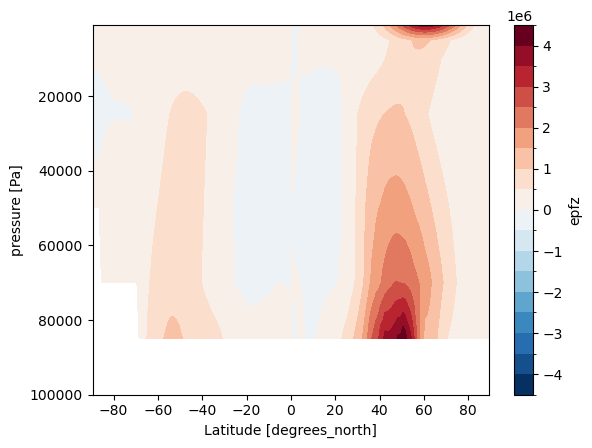

In [ ]:
epfz = epfz.where(epfz.level < 100000.) # remove surface value because appears too large
epfz.plot.contourf(levels=21, yincrease=False)

In [6]:
# Rescale DataArray for log-pressure to pressure or visa versa
def pressure_scaling(da, p0=1e3, multiply_factor=True):

    """
        Converts log-pressure coordinates to pressure coordinates
        or visa versa.
        ----------------------------------------------------------
        
        Input: xr.DataArray in log-pressure/pressure coordinates
                - (pressure, latitude)
        
        Output: xr.DataArray in pressure/log-pressure coordinates
                - (pressure, latitude)
    """

    # define dimensions
    lat = da.lat.values
    level = da.level.values

    # define and calculate ratio
    p_ratio = np.repeat(level/p0, lat.size).reshape((level.size,lat.size))

    if multiply_factor:
        da_new = da * p_ratio
    else:
        da_new = da / p_ratio

    return da_new

In [7]:
epfz_scaled = pressure_scaling(epfz)
epfz_scaled

<xarray.DataArray 'epfz' (level: 8, lat: 180)>
dask.array<mul, shape=(8, 180), dtype=float64, chunksize=(8, 180), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

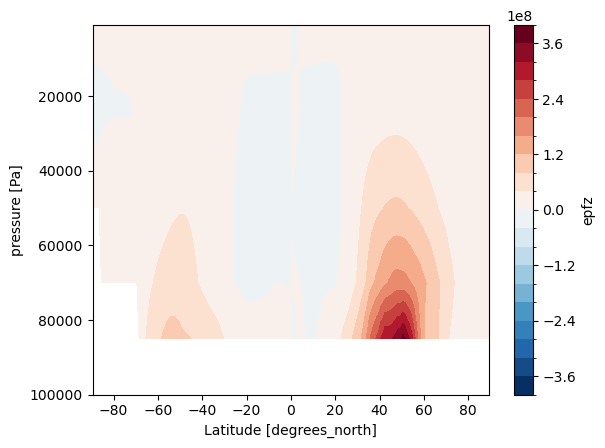

In [8]:
epfz_scaled.plot.contourf(levels=21, yincrease=False)